# ABN Amro - Sustainability Urbanisation Case

---

## Outline
- Part 0: Import raw data (**Specify data filepath here**)
- Part 1: Exploratory analysis (Summary statistics, Outliers, Segmentation, Trend/Seasonality)
- Part 2: Feature engineering (Parsing, Scaling, Missing data, Seasonality)
- Part 3: Model specification (OLS, LASSO, Random Forest)
- Part 4: Performance evaluation

**Note:** for practical reasons, I recommend working with a subsample of the data. Total runtime of the notebook is kept light to enable easy/timely evaluation in case any users would be interested in looking under the hood.

---
# Part 0: Importing Data & Specify filepath

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from datetime import datetime

# Set the style & colors for the plots
sns.set_style('darkgrid')
_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

**Specify Filepath following the example below:**

In [2]:
data_filepath = "C:/Users/richi/Downloads/Case_data/" # Change here

bm_full = pd.read_csv(data_filepath + "building_metadata.csv") # dim (1_449, 6)
bmr_full = pd.read_csv(data_filepath + "building_meter_readings.csv") # dim (20_216_100, 4)
wd_full = pd.read_csv(data_filepath + "weather_data.csv") # dim (139_773, 9)

Merge tables & random sample subset of observations for development convenience
- **Specify subsample (*n*) here**
- n = 100.000, is a convenient number for quick runtimes with reasonable performance. Larger/smaller samples should work fine too.

In [3]:
n = 100000

bm = bm_full.sample(min(len(bm_full), n), random_state = 0)
bmr = bmr_full.sample(min(len(bmr_full), n), random_state = 0)
wd = wd_full.sample(min(len(wd_full), n), random_state = 0)

# Merge tables (some rows may get lost - remaining rows (after loss) are displayed print statement at the end)
merged_df = bm.merge(bmr, on='building_id', how='inner')
df = merged_df.merge(wd, on=['site_id', 'timestamp'], how='inner')

# save original dataset
raw_data_merged = df.copy()

print(df.shape, df.columns)

(70754, 16) Index(['site_id', 'building_id', 'primary_use', 'square_feet', 'year_built',
       'floor_count', 'meter', 'timestamp', 'meter_reading', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed'],
      dtype='object')


---
# Part 1: Exploratory Analysis

## 1.1 Summary statistics

In [4]:
# Continuous variables
df.describe().round(2)

,site_id,building_id,square_feet,year_built,floor_count,meter,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,70754.00,70754.00,70754.00,28086.00,12301.00,70754.00,70754.00,70730.00,40009.00,70717.00,57803.00,66665.00,66013.00,70563.00
mean,7.99,799.01,108136.29,1968.36,4.17,0.66,2357.07,15.93,1.93,7.74,0.82,1016.14,173.46,3.39
std,5.09,426.28,118039.39,30.16,4.00,0.93,160533.97,10.95,2.42,10.15,7.44,7.04,114.15,2.28
min,0.00,0.00,283.00,1900.00,1.00,0.00,0.00,-27.80,0.00,-35.00,-1.00,968.30,0.00,0.00
25%,3.00,395.00,32766.00,1951.00,1.00,0.00,18.43,8.30,0.00,0.00,0.00,1011.70,80.00,2.10
50%,9.00,896.00,72332.00,1969.00,3.00,0.00,79.24,16.70,0.00,8.90,0.00,1016.10,180.00,3.10
75%,13.00,1177.00,139683.00,1993.00,6.00,1.00,270.79,23.90,4.00,16.10,0.00,1020.60,280.00,4.60
max,15.00,1448.00,875000.00,2017.00,26.00,3.00,17971300.00,47.20,9.00,26.10,343.00,1044.90,360.00,17.00


In [5]:
# Categorical variables
df.describe(include=['object'])

,primary_use,timestamp
count,70754,70754
unique,16,8774
top,Education,2016-11-29 04:00:00
freq,28269,24


## 1.2 Evaluating distributions & handling (multivariate) outliers
Plot target variable ``meter_reading`` distributions:
- significant **outliers identified through visual inspection**

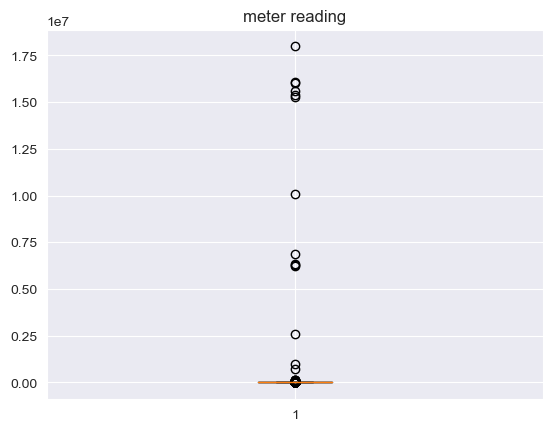

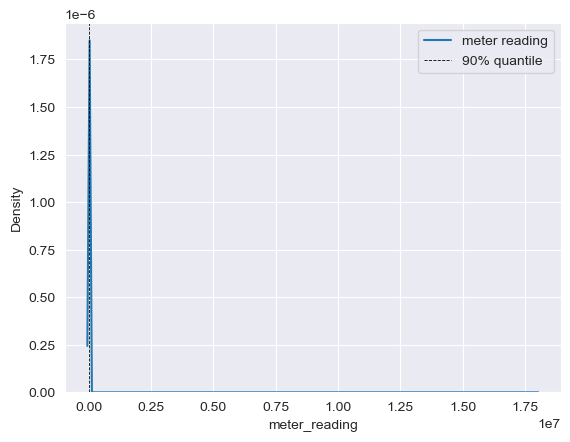

In [6]:
plt.boxplot(df["meter_reading"])
plt.title("meter reading")
plt.show()
 
sns.kdeplot(df["meter_reading"], label = "meter reading")
plt.axvline(x = 2002, color = "black", linestyle = "--", linewidth = "0.6", label = "90% quantile")
plt.legend()
plt.show()

Inspect the outliers after aggregating data per ```building_id``` (main VOI: ```meter_reading```):
- Univariate outliers per observation / building
- Correlation between meter_reading & other *building characteristics* (```square_feet```, ```floor_count```, ```year_built```, ```air_temperature```)

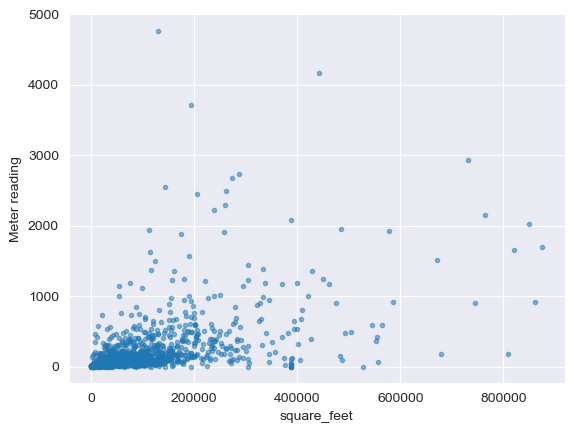

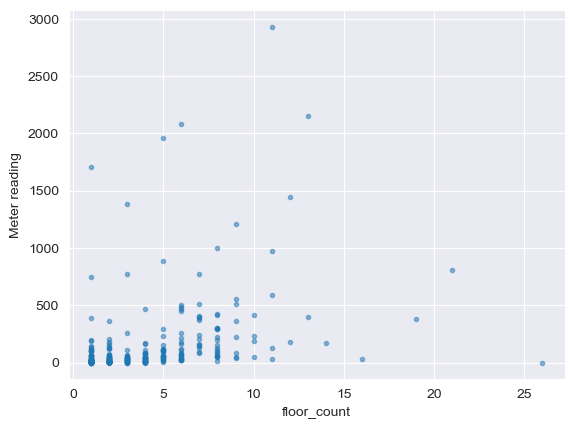

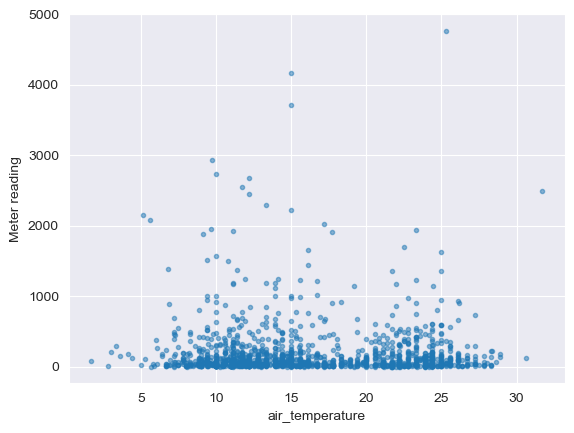

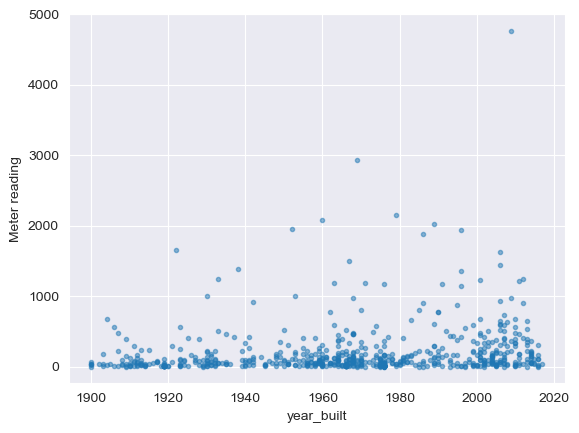

In [7]:
# Aggregating the dataframe by "building_id" and taking the mean
df_building_mean = df.groupby('building_id').mean(numeric_only=True).reset_index()
df_building_median = df.groupby('building_id').median(numeric_only=True).reset_index()

# To highlight the buildings with the highest energy consumption (aggregated by mean/median)
df_building_mean.sort_values(by = "meter_reading", ascending = False)
df_building_median.sort_values(by = "meter_reading", ascending = False)
df_building_mean["meter_reading"].describe().round()
df_building_median["meter_reading"].describe().round()

# Use median for more robust insights
for building_characteristic in ["square_feet", "floor_count", "air_temperature", "year_built"]:
    plt.scatter(df_building_median[building_characteristic], df_building_median["meter_reading"], alpha = 0.5, marker = ".")
    # plt.scatter(df_building_mean[building_characteristic], df_building_mean["meter_reading"], alpha = 0.5, marker = ".")
    plt.ylabel("Meter reading")
    plt.xlabel(building_characteristic)
    plt.show()

Simple implementation to **remove outliers using interquantile range (IQR) method**, based on the target variable ```meter_reading``` (univariate)

In [8]:
def remove_outliers(df, column_name):
    # Calculate Q1, Q3, and IQR
    Q1 = df[column_name].quantile(0.10)
    Q3 = df[column_name].quantile(0.90)
    IQR = Q3 - Q1
    
    # Define bounds
    lower_bound = max(0, Q1 - 1.5 * IQR) # truncate at 0, remove negative readings
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
    num_outliers = len(outliers)
    
    # Remove outliers
    df_no_outliers = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    
    # Print actions
    print(f"Number of outliers removed ({column_name}): {num_outliers}/{len(df)} ({round(num_outliers/len(df) * 100, 1)} %)")
    print(f"Lower and Upper bounds for outliers: ({lower_bound}, {upper_bound})")
    
    return df_no_outliers, num_outliers, (lower_bound, upper_bound)

df_no_outliers, num_removed, bounds = remove_outliers(df, "meter_reading")  

Number of outliers removed (meter_reading): 2733/70754 (3.9 %)
Lower and Upper bounds for outliers: (0, 2002.067950000002)


Quck check on effect of outlier removal

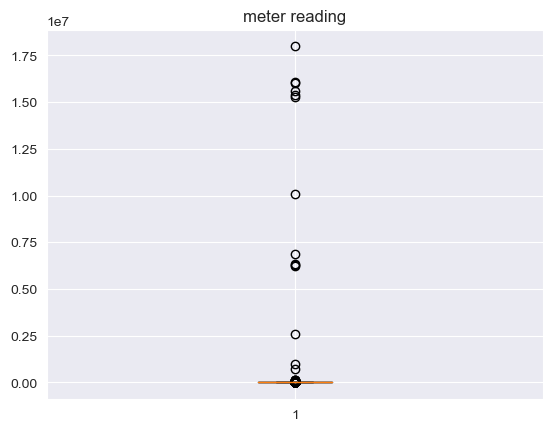

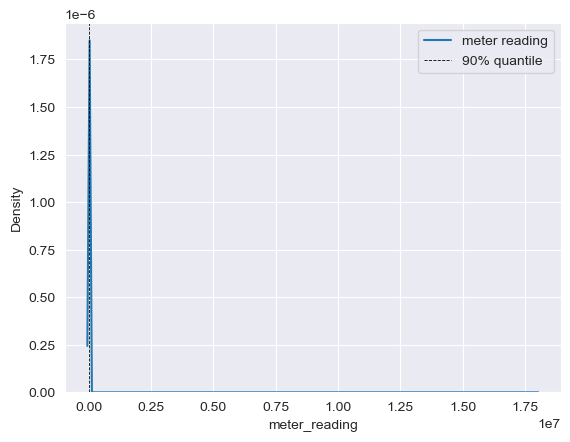

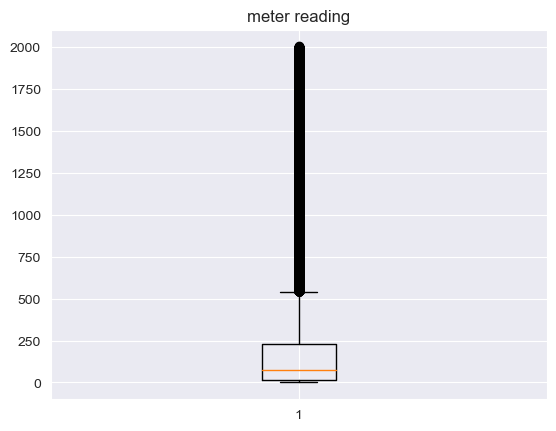

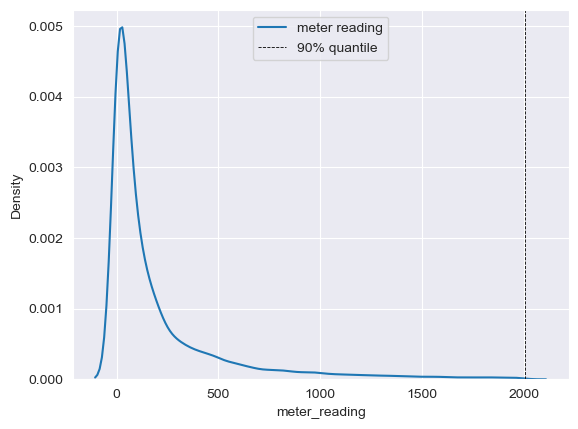

In [9]:
# Same plots as above
plt.boxplot(df["meter_reading"])
plt.title("meter reading")
plt.show()
 
sns.kdeplot(df["meter_reading"], label = "meter reading")
plt.axvline(x = 2002, color = "black", linestyle = "--", linewidth = "0.6", label = "90% quantile")
plt.legend()
plt.show()

# Same plots as above
plt.boxplot(df_no_outliers["meter_reading"])
plt.title("meter reading")
plt.show()
 
sns.kdeplot(df_no_outliers["meter_reading"], label = "meter reading")
plt.axvline(x = 2002, color = "black", linestyle = "--", linewidth = "0.6", label = "90% quantile")
plt.legend()
plt.show()

## 1.3 Segmentation & Clusters

Check for sensible segmentation of observations by evaluation distributions using the following categorical data:
- Measurement device type (```meter```)
- Building neighbourhood (```site_id```)
- Building's ```primary use```

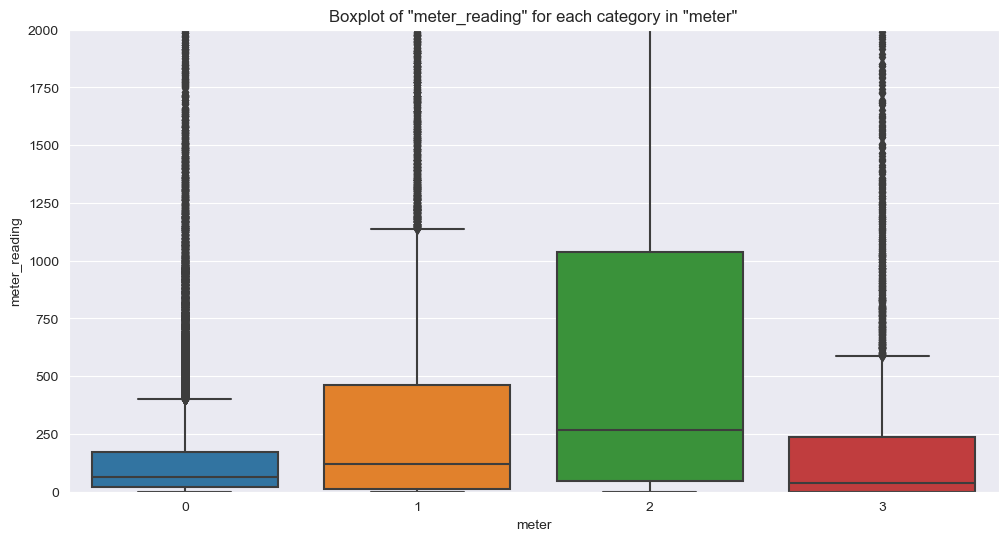

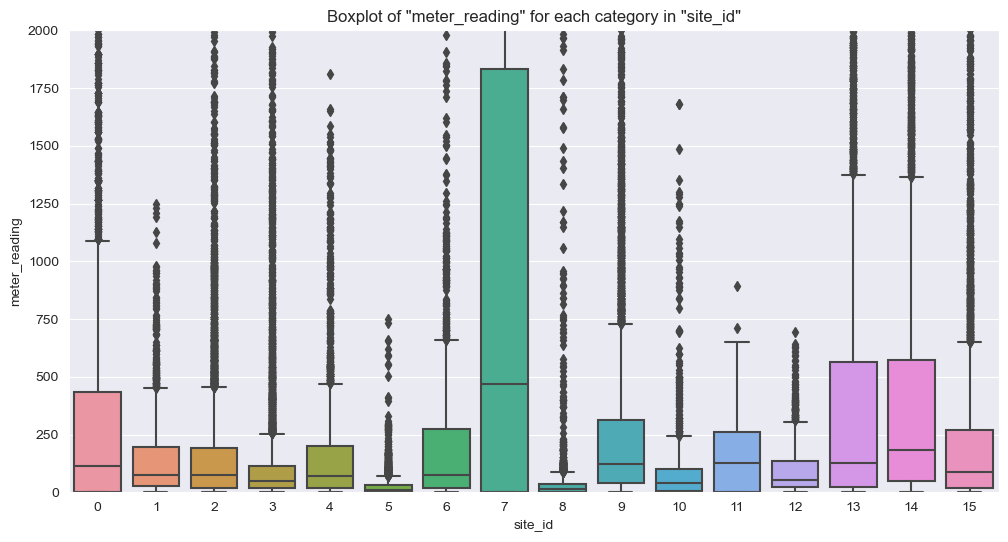

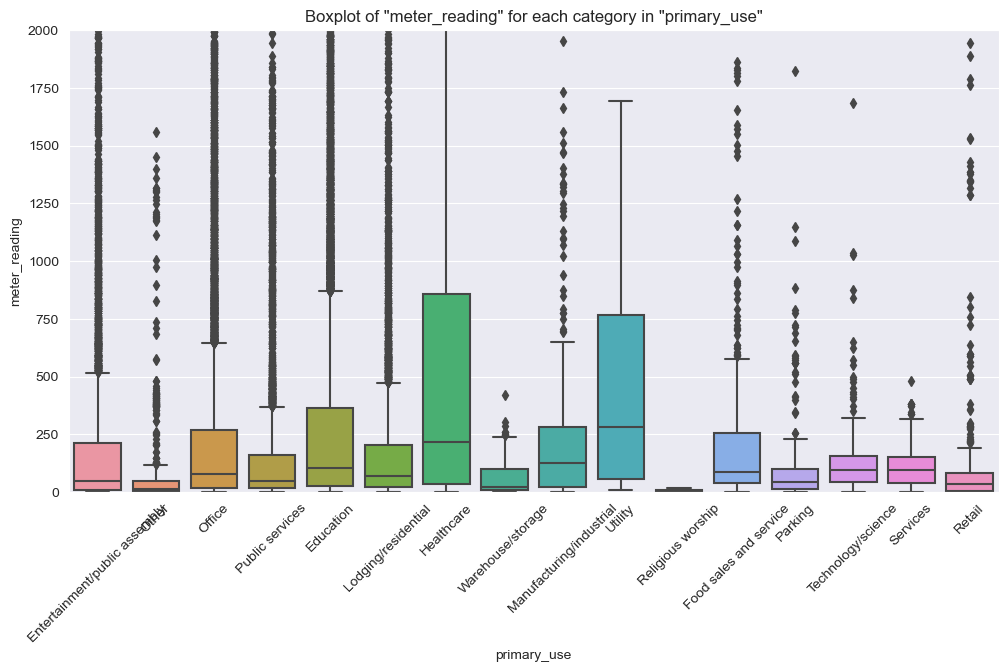

In [10]:
# Boxplot comparing different categories
def boxplot_for_categories(df, categorical_col, target_col):
    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(data=df, x=categorical_col, y=target_col)  # 'ax' now holds the axis object
    plt.title(f'Boxplot of "{target_col}" for each category in "{categorical_col}"')
    # Rotate Xticks for readability
    if rotate_axis == True:
        plt.xticks(rotation=45) 
    # Setting the y-axis limits
    ax.set_ylim([lower_bound, upper_bound])
    plt.show()

# Define your plot bounds (for convenient horizont comparison)
lower_bound, upper_bound = 0, 2000

# Make boxplots
rotate_axis = False
boxplot_for_categories(df, 'meter', 'meter_reading') # per meter
boxplot_for_categories(df, 'site_id', 'meter_reading') # per site

rotate_axis = True
boxplot_for_categories(df, 'primary_use', 'meter_reading') # Per primary use

## 1.4 Trends & Seasonality
Group data per day (```timestamp```), by aggregating through means and medians

In [11]:
def aggregate_to_daily(data, voi):
    # Convert the "timestamp" column to datetime format if it's not already
    if not pd.api.types.is_datetime64_any_dtype(data['timestamp']):
        data['timestamp'] = pd.to_datetime(data['timestamp'])
    
    # Set the "timestamp" column as the index
    data = data.set_index('timestamp')
    
    # Resample the data to daily frequency and calculate the mean and median
    daily_data = data.resample('D').agg({voi: ['mean', 'median']}).reset_index()
    
    # Flatten multi-level column names
    daily_data.columns = ['_'.join(col).rstrip('_') for col in daily_data.columns.values]
    
    return daily_data

df_daily = aggregate_to_daily(df, "meter_reading")
df_daily.head()

,timestamp,meter_reading_mean,meter_reading_median
0,2016-01-01,265.511565,55.34750
1,2016-01-02,482.965595,53.22740
2,2016-01-03,773.675011,34.35960
3,2016-01-04,412.283057,66.30515
4,2016-01-05,466.382790,58.87020


Plot ```meter_reading``` over time though a **moving average** of 7 to account for weekday-seasonality.

In [12]:
def rolling_trend(data, voi):    
    window_size = 7 # week
    
    # Group by timestamp and take the mean for the given variable of interest (voi)
    data_avg = data.groupby("timestamp")[voi].mean().reset_index()
    
    # Compute the moving average
    data_avg['rolling_mean'] = data_avg[voi].rolling(window=window_size).mean()
    
    # Using the first date in each window for the timestamp
    data_avg['rolling_timestamp'] = data_avg["timestamp"].shift(window_size - 1)

    # Drop NaN values
    data_avg = data_avg.dropna(subset=['rolling_mean', 'rolling_timestamp'])
    
    x = data_avg['rolling_timestamp']
    y = data_avg['rolling_mean']
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label=f"Moving Avg of {voi}")
    
    # Formatting for better visualization
    plt.gcf().autofmt_xdate()  # Auto-format the x-axis for datetime values
    plt.xlabel("Timestamp")
    plt.ylabel(f"Moving Avg")
    plt.title(f"Moving Average trend over time")
    plt.legend()
    plt.tight_layout()
    plt.title("Moving Average (7 days)")
    plt.show()
    
    return [x, y]

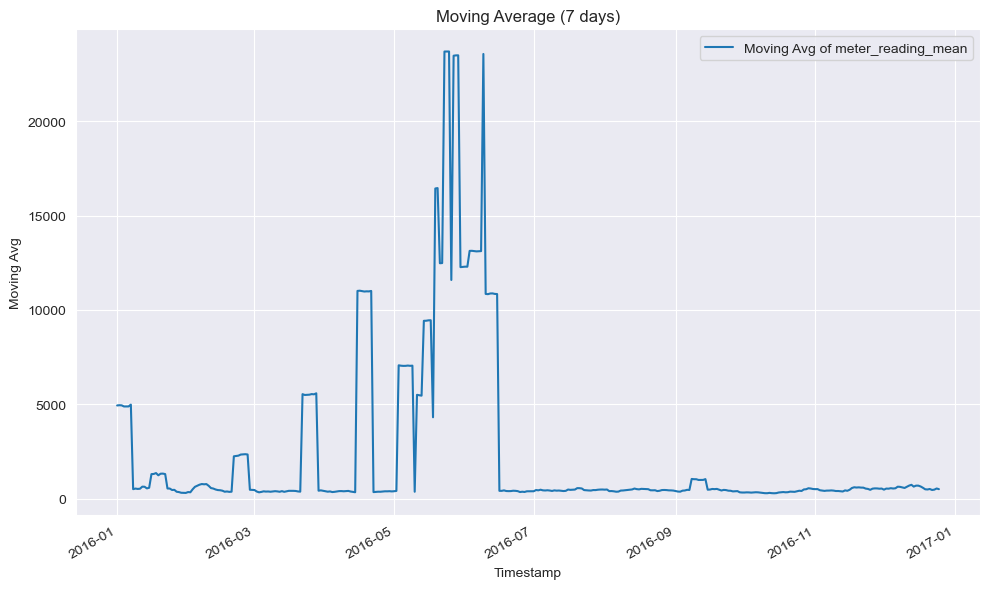

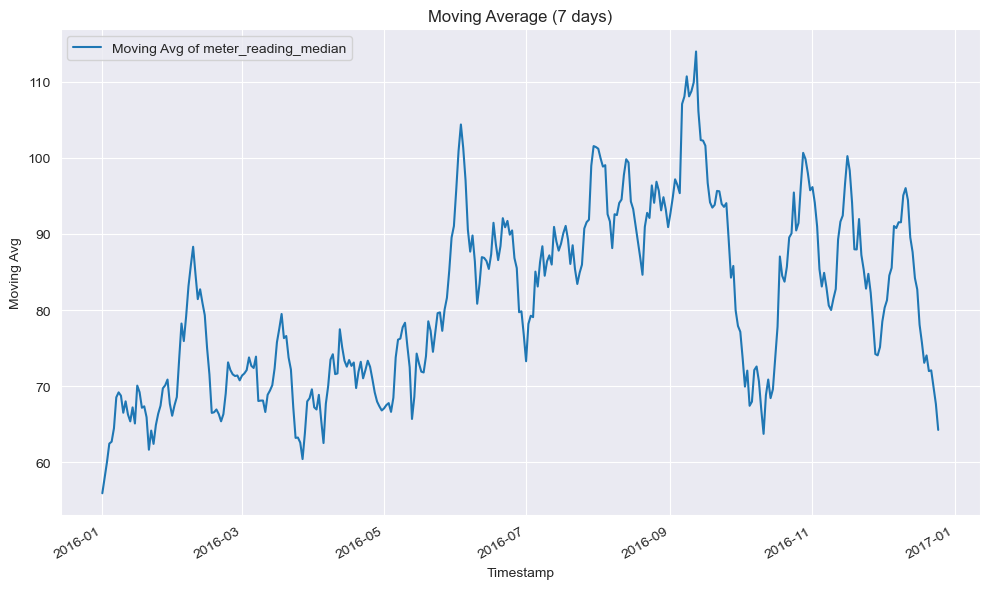

Number of outliers removed (meter_reading_mean): 15/366 (4.1 %)
Lower and Upper bounds for outliers: (0, 1356.5536443154947)


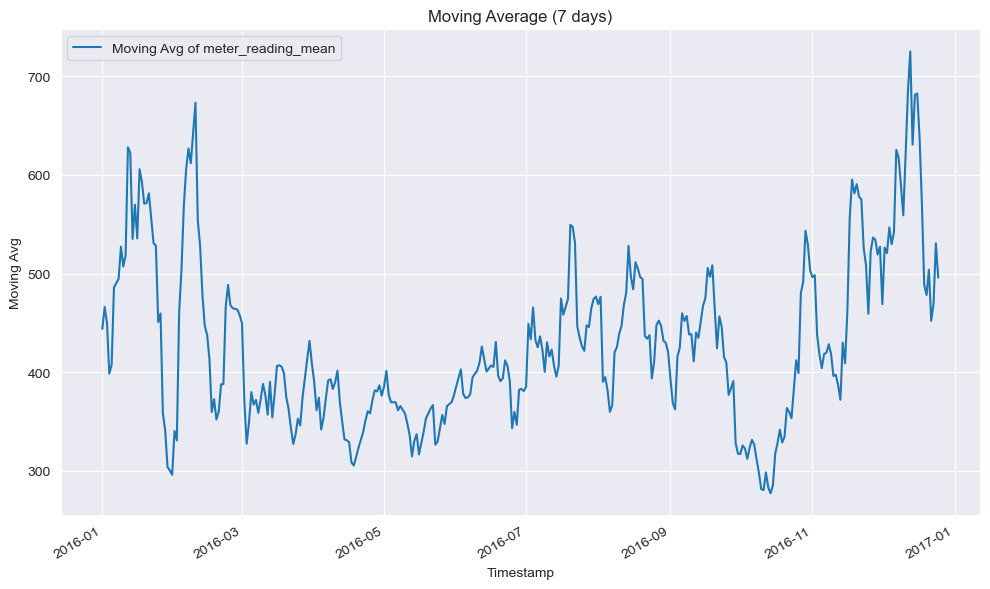

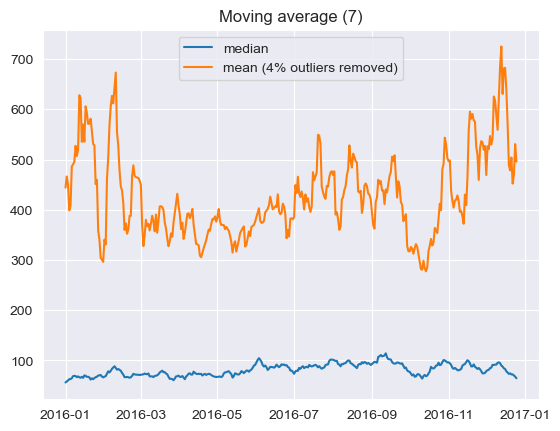

In [13]:
# Mean & median
ma7_mean = rolling_trend(df_daily, "meter_reading_mean")
ma7_median = rolling_trend(df_daily, "meter_reading_median")

# Mean after removing outliers
df_daily_no_outliers, num_removed, bounds = remove_outliers(df_daily, "meter_reading_mean")  
ma7_mean_no_outliers = rolling_trend(df_daily_no_outliers, "meter_reading_mean")

plt.plot(ma7_median[0], ma7_median[1], label = "median")
plt.plot(ma7_mean_no_outliers[0], ma7_mean_no_outliers[1], label = "mean (4% outliers removed)")
plt.legend()
plt.title("Moving average (7)")
plt.show()

**Seasonal Decomposition:**
- Decomposing the time series into its constituent parts (trend, seasonality, residuals) can visually indicate seasonality.
- **Augmented Dickey-Fuller (ADF) Test for Trends**: This tests the null hypothesis that a unit root is present in a time series sample. A unit root would imply that the time series is non-stationary and has some form of structure (such as a trend).
- **Ljung-Box Test for Seasonality**: After the STL decomposition, you can apply the Ljung-Box test on the residuals to check if they are white noise. If they aren't, this can imply the presence of seasonality or some other form of autocorrelation.

ADF Statistic: -2.6169141422694735
p-value: 0.08955160399991258
Critical Value (1%): -3.450081345901191
Critical Value (5%): -2.870232621465807
Critical Value (10%): -2.571401168202517
Ljung-Box Test Statistic: l
p-value: l


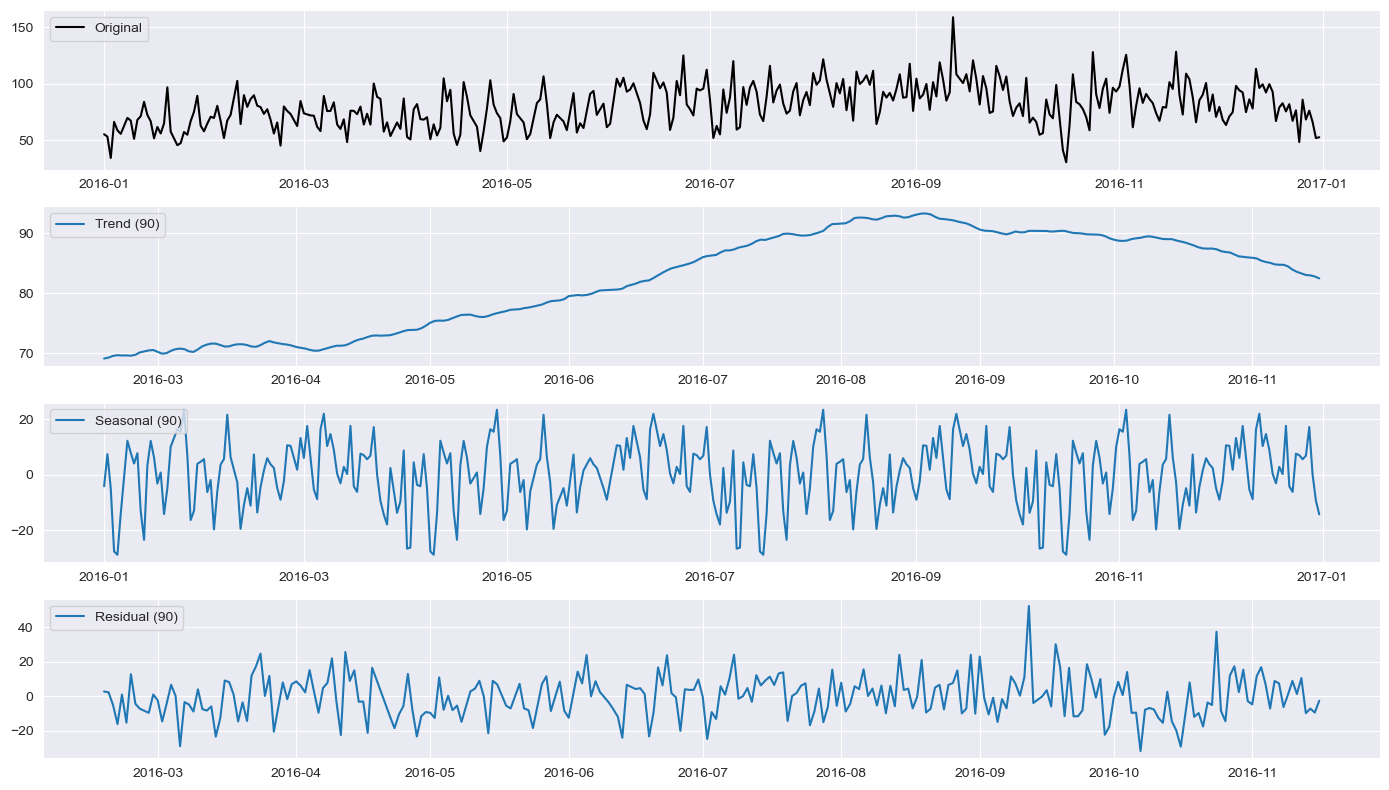

In [19]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

def decompose_time_series(ts, period=90):
    plot_color = _colors[0] # helpful when comparing different period horizons
    
    # Decompose the time series
    decomposition = sm.tsa.seasonal_decompose(ts, model='additive', period=period)
    
    # Plot the components
    plt.figure(figsize=(14, 8))
    plt.subplot(411)
    plt.plot(ts, label='Original', color="black")
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(decomposition.trend, label=f'Trend ({period})', color=plot_color)
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label=f'Seasonal ({period})', color=plot_color)
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(decomposition.resid, label=f'Residual ({period})', color=plot_color)
    plt.legend(loc='upper left')
    plt.tight_layout()
    
    # ADF Test
    adf_result = adfuller(ts)
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    for key, value in adf_result[4].items():
        print(f"Critical Value ({key}): {value}")
    
    # Assuming the residuals from the decomposition are stored in decomposition.resid
    # Ljung-Box Test
    lb_test_stat, lb_p_value = acorr_ljungbox(decomposition.resid.dropna(), lags=[period])
    print(f"Ljung-Box Test Statistic: {lb_test_stat[0]}")
    print(f"p-value: {lb_p_value[0]}")
    
    return decomposition

# Usage
ts = df_daily_no_outliers.set_index('timestamp')['meter_reading_median']
decomposition = decompose_time_series(ts)

---
# Part 2: Feature Engineering

### Binning ``year_built``: parsing *continuous* to *custom categorical* 
- Pre-2000: Bins of 20 year
- Post-2000: Bins of 1 year

**Note:**
- Other categorical variables (```primary_use```, ```site_id```, ```meter```, ```building_id```, ```season```) are categorised using **one-hot encoding** (see: model specifcation function)

In [20]:
def categorize_year(year_series):
    # Bins and labels for years prior to 2000
    bins_1900s = list(range(1900, 2000, 20)) + [2000]
    labels_1900s = [f"{start}-{start+9}" for start in bins_1900s[:-1]]

    # Bins and labels for years from 2000 onwards
    bins_2000s = list(range(2000, 2018))
    labels_2000s = [str(year) for year in bins_2000s[:-1]]

    # Combine bins and labels
    bins = bins_1900s + bins_2000s
    labels = labels_1900s + labels_2000s

    return pd.cut(year_series, bins=bins, labels=labels, right=False,  duplicates='drop')

# If year_built = continuous, transform to categorical. Else skip
if type(df["year_built"][0]) != str:
     df['year_built'] = categorize_year(df['year_built'])

### Scaling continuous ```square_feet```, ```floor_count```, ```air_temperature```
To prevent variables with high numerical values unintentionally dominating during fitting

In [21]:
# Define the features we want to scale
features = ['square_feet', 'floor_count', "air_temperature"]

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform
df[features] = scaler.fit_transform(df[features])

### Handling missing values in ```Floor_count``` (KNN imputation)

In [22]:
# Count NaN values
df.isna().sum()

site_id                   0
building_id               0
primary_use               0
square_feet               0
year_built            42691
floor_count           58453
meter                     0
timestamp                 0
meter_reading             0
air_temperature          24
cloud_coverage        30745
dew_temperature          37
precip_depth_1_hr     12951
sea_level_pressure     4089
wind_direction         4741
wind_speed              191
dtype: int64

Impute NaN values of ```floor_count``` with a predictive value, based on building characteristics: ```primary_use```, ```square_feet```, ```year_built```. This implementation leverage K-nearest Neighbours (KNN)

runtime: approx 5 min

In [23]:
# Track total runtime
_start_time = datetime.now()

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# Prepare the data
df_temp = raw_data_merged[["floor_count", "primary_use", "square_feet", "year_built"]].copy()

# Convert "primary_use" to numeric since KNN works with numeric data
label_enc = LabelEncoder()
df_temp["primary_use"] = label_enc.fit_transform(df_temp["primary_use"])

# Apply KNN imputation
imputer = KNNImputer(n_neighbors=5)  # you can adjust the number of neighbors if needed
df_temp_imputed = imputer.fit_transform(df_temp)

# Replace original "floor_count" column with imputed data
df["floor_count"] = df_temp_imputed[:, 0]

# Print execution time
print(f"Total runtime:  {datetime.now() - _start_time}")

Total runtime:  0:06:25.037547


### Creating ```Seasonality``` variable
Create a new ```season``` variable through the ```timestamp``` variable by assigning months to seasons (quick and dirty implementation)

In [24]:
import pandas as pd

def add_seasonality(df, timestamp_col='timestamp'):
    # Convert the timestamp column to datetime
    df[timestamp_col] = pd.to_datetime(df[timestamp_col])

    # Extract month from the timestamp
    df['month'] = df[timestamp_col].dt.month

    # Map month to season
    def month_to_season(month):
        if 3 <= month <= 5:
            return 'Spring'
        elif 6 <= month <= 8:
            return 'Summer'
        elif 9 <= month <= 11:
            return 'Fall'
        else:
            return 'Winter'

    df['season'] = df['month'].apply(month_to_season)

    # Drop the month column as it's just an intermediate column
    df = df.drop('month', axis=1)
    
    return df

df = add_seasonality(df)
df_no_outliers = add_seasonality(df_no_outliers)

---
# Part 3: Model Specification
- **Linear Regression**:
  - *Pros*: Simple, Fast
  - *Cons*: Limited complexity, Overfitting
  - *Assumptions/Requirements*: Linearity, Independence
  - *Interpretability*: High (Coefficients)

- **Random Forest**:
  - *Pros*: Handles non-linearity, Feature importance
  - *Cons*: Slow on large data, Overfitting if not tuned
  - *Assumptions/Requirements*: No assumptions on feature scale or distribution
  - *Interpretability*: Moderate (Feature importance)

- **LASSO**:
  - *Pros*: Feature selection, Handles multicollinearity
  - *Cons*: Can overly simplify, Tuning required
  - *Assumptions/Requirements*: Linearity, Independence
  - *Interpretability*: High (Sparse coefficients)

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor

def model_specification(df, model_type="linear"):
    # Columns you want to keep
    columns_to_keep = ["meter_reading", "square_feet", "air_temperature", 
                       "primary_use", "year_built", "site_id", 
                       "meter", "building_id", "floor_count", "season"]

    # Drop columns not in the list
    df_pred = df[columns_to_keep]

    # Drop all nan rows
    print(df_pred.shape)
    df_pred = df_pred.dropna(axis=0, how='any')
    print("remove all nan rows: ", df_pred.shape)
    
    # Optionally remove 0 readings
    # df_pred = df_pred[df_pred["meter_reading"] != 0]
    # print("remove all zero meter readings: ", df_pred.shape)

    # One-hot encode categorical columns
    df_encoded = pd.get_dummies(df_pred, columns=["primary_use", "site_id", "meter", "building_id", "season"])

    # Split the data into train and test sets
    X = df_encoded.drop("meter_reading", axis=1)
    y = df_encoded["meter_reading"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Choose model
    if model_type == "linear":
        model = LinearRegression()
    elif model_type == "lasso":  # L1 Regularization
        model = Lasso()
    elif model_type == "random_forest":
        model = RandomForestRegressor()
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    model.fit(X_train, y_train)
    
    return X_train, X_test, y_train, y_test, model


_start_time = datetime.now()
X_train, X_test, y_train, y_test, model = model_specification(df_no_outliers, model_type="random_forest")
print(f"Total runtime:  {datetime.now() - _start_time}")

(68021, 10)
remove all nan rows:  (7709, 10)
Total runtime:  0:00:11.033708


---
# Part 4: Performance Evaluation
**Accuracy Metrics**
- Mean absolute error
- Median absolute error: included for increased metric robustness to outliers

**Visualisations**
- Residual distribution
- Residual correlation with energy consumption volume


Training:
- Mean Absolute Error: 19.005668130396344 
- Median Absolute Error: 5.1613824999999895
Test:
- Mean Absolute Error: 50.31933725816058 
- Median Absolute Error: 12.763411666666665


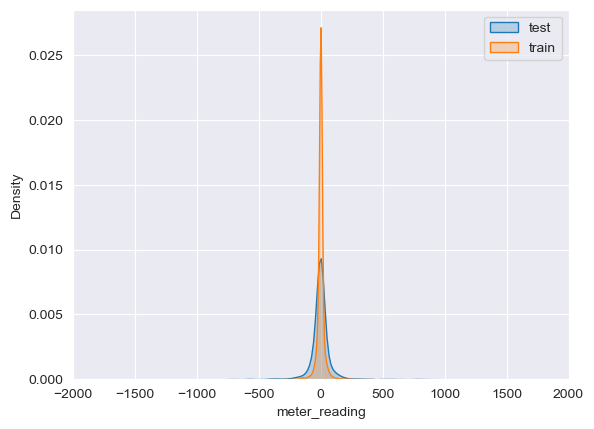

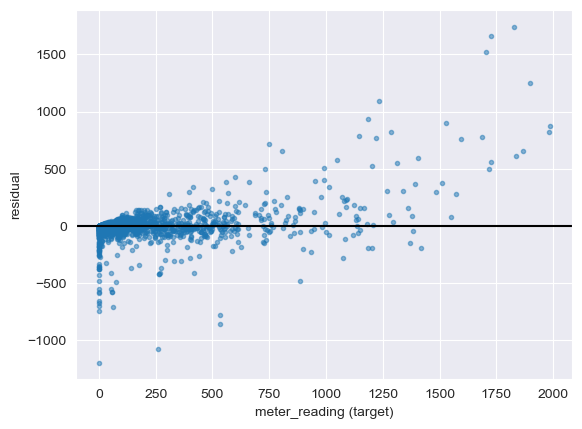

In [26]:
def model_evaluation(X_train, X_test, y_train, y_test, model):
    # Make predictions on the training set
    y_train_pred = model.predict(X_train)
    train_residuals = y_train - y_train_pred

    # Calculate the mean/edian absolute errors
    mean_abs = metrics.mean_absolute_error(y_train, y_train_pred)
    median_abs = metrics.median_absolute_error(y_train, y_train_pred)
    print(f"Training:\n- Mean Absolute Error: {mean_abs} \n- Median Absolute Error: {median_abs}")

    # Make predictions
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    # Calculate the mean/edian absolute errors
    mean_abs = metrics.mean_absolute_error(y_test, y_pred)
    median_abs = metrics.median_absolute_error(y_test, y_pred)
    print(f"Test:\n- Mean Absolute Error: {mean_abs} \n- Median Absolute Error: {median_abs}")

    # Plot distribution
    sns.kdeplot(residuals, fill = True, label = "test")
    sns.kdeplot(train_residuals, fill = True, label = "train")
    plt.xlim([-2000, 2000])
    plt.legend()
    plt.show()

    # Plot distribution of residuals relative to numerical values of target
    plt.scatter(y_test, residuals, alpha = 0.5, marker = ".")
    plt.axhline(y = 0, color = "black")
    plt.xlabel("meter_reading (target)")
    plt.ylabel("residual")
    plt.show()
    
model_evaluation(X_train, X_test, y_train, y_test, model)